# COMSOL to Matplotlib figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib inline
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import glob as glob
import re
import os

import scipy.optimize

import skimage.io
import skimage.filters
import skimage.morphology
import skimage.transform

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets

import pandas as pd

from tqdm.notebook import tqdm as tqdm

import panel as pn
pn.extension()

Phillips Group Plotting Style

In [2]:
rc = {'lines.linewidth': 1.25,
          'axes.labelsize': 16, # Modified originally 8
          'axes.titlesize': 18, # Modified originally 9
          'axes.facecolor': '#E3DCD0',
          'xtick.labelsize': 14, # Modified originally 7
          'ytick.labelsize': 14, # Modified originally 7
          #'font.family': 'Lucida Sans Unicode',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.color': '#ffffff',
          'legend.fontsize': 8,
          'figure.dpi': 300,
          'savefig.dpi': 300}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('xtick.major', pad=1)
plt.rc('ytick.major', pad=1)
plt.rc('mathtext', fontset='stixsans', sf='sansserif')
plt.rc('figure', figsize=[7, 5]) # Modified originally figsize=[3.5, 2.5]
plt.rc('svg', fonttype='none')
plt.rc('legend', title_fontsize='8', frameon=True, 
        facecolor='#E3DCD0', framealpha=1)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)

In [3]:
# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 8
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
mpl.rc("figure", dpi=200)

In [46]:
file_path = '../../data/COMSOL/20230525_ATP_Depletion_2D_eqn-input_correctedunits/'
file_name = 'ATP_Depletion_2D_steadystate-mot-hardsphere(mmax5)_eqn_D120_gamma=0.5'
file_type = '.csv'
comment = '%'

ATP_prof_df = pd.read_csv(file_path + file_name + file_type, comment=comment, names=["position", "ATP (mol/m^3)"])

In [47]:
ATP_prof_df

,position,ATP (mol/m^3)
0,0.000000e+00,2.999742e-05
1,1.705880e-07,2.999742e-05
2,3.699085e-07,2.999742e-05
3,1.293647e-06,2.999742e-05
4,1.830088e-06,2.999742e-05
...,...,...
4300,1.854817e-04,1.531100e-07
4301,1.926629e-04,1.531185e-07
4302,1.927408e-04,1.531186e-07
4303,1.928172e-04,1.531186e-07


In [48]:
depth = 60e-6 #m
molperm3_to_uM = 1e3
ATP_prof_df['ATP Conc'] = ATP_prof_df['ATP (mol/m^3)']/depth * molperm3_to_uM

In [49]:
file_type = '.txt'
text_info = pd.read_csv(file_path + file_name + file_type, names=["position", "ATP Conc"])

In [50]:
text_info.head(9)

,position,ATP Conc
0,% Model: 20230525-ATP_Depletion_2...,NaN
1,% Version: COMSOL 5.6.0.401,NaN
2,% Date: May 26 2023,15:01
3,% Dimension: 1,NaN
4,% Nodes: 4305,NaN
5,% Expressions: 1,NaN
6,% Description: Line graph,NaN
7,% cln2x,Height
8,%Time 1-41 interval 1 (line plot range and int...,seconds interval multiplier 100 (time depende...


In [51]:
t_start = 0
t_end = 40 # max plotting range
interval = 1 #plotting interval

numb_times = int((t_end+interval)/interval)
times = np.linspace(t_start, t_end, numb_times)*(100/60) #non-dim note this times 5 corresponds to the time dependent interval which was 0-600s intervals of 5s not the above interal whch is for plotting
tot_points = len(ATP_prof_df['position'])
numb_points = int(tot_points/numb_times)
#half_scale = int(ATP_prof_df['position'][numb_points-1] / 2) #only if cut line spans thewhole aster rather than the radius

time_ls = []
for t in times:
    for i in range(numb_points):
        time_ls.append(t)

In [52]:
print(tot_points)
print(numb_times)
print(numb_points)
print(len(time_ls))

4305
41
105
4305


In [53]:
ATP_prof_df['time (min)'] = time_ls

In [54]:
ATP_prof_df.head(numb_points)

,position,ATP (mol/m^3),ATP Conc,time (min)
0,0.000000e+00,0.00003,499.956981,0.0
1,1.705880e-07,0.00003,499.956981,0.0
2,3.699085e-07,0.00003,499.956981,0.0
3,1.293647e-06,0.00003,499.956981,0.0
4,1.830088e-06,0.00003,499.956981,0.0
...,...,...,...,...
100,1.854817e-04,0.00003,499.991396,0.0
101,1.926629e-04,0.00003,499.991396,0.0
102,1.927408e-04,0.00003,499.991396,0.0
103,1.928172e-04,0.00003,499.991396,0.0


Scale the x-axis data

In [55]:
ATP_prof_df['position'] = (ATP_prof_df['position']) *1000000 # multiplied by m to micron conversion

In [56]:
times

array([ 0.        ,  1.66666667,  3.33333333,  5.        ,  6.66666667,
        8.33333333, 10.        , 11.66666667, 13.33333333, 15.        ,
       16.66666667, 18.33333333, 20.        , 21.66666667, 23.33333333,
       25.        , 26.66666667, 28.33333333, 30.        , 31.66666667,
       33.33333333, 35.        , 36.66666667, 38.33333333, 40.        ,
       41.66666667, 43.33333333, 45.        , 46.66666667, 48.33333333,
       50.        , 51.66666667, 53.33333333, 55.        , 56.66666667,
       58.33333333, 60.        , 61.66666667, 63.33333333, 65.        ,
       66.66666667])

  0%|          | 0/41 [00:00<?, ?it/s]

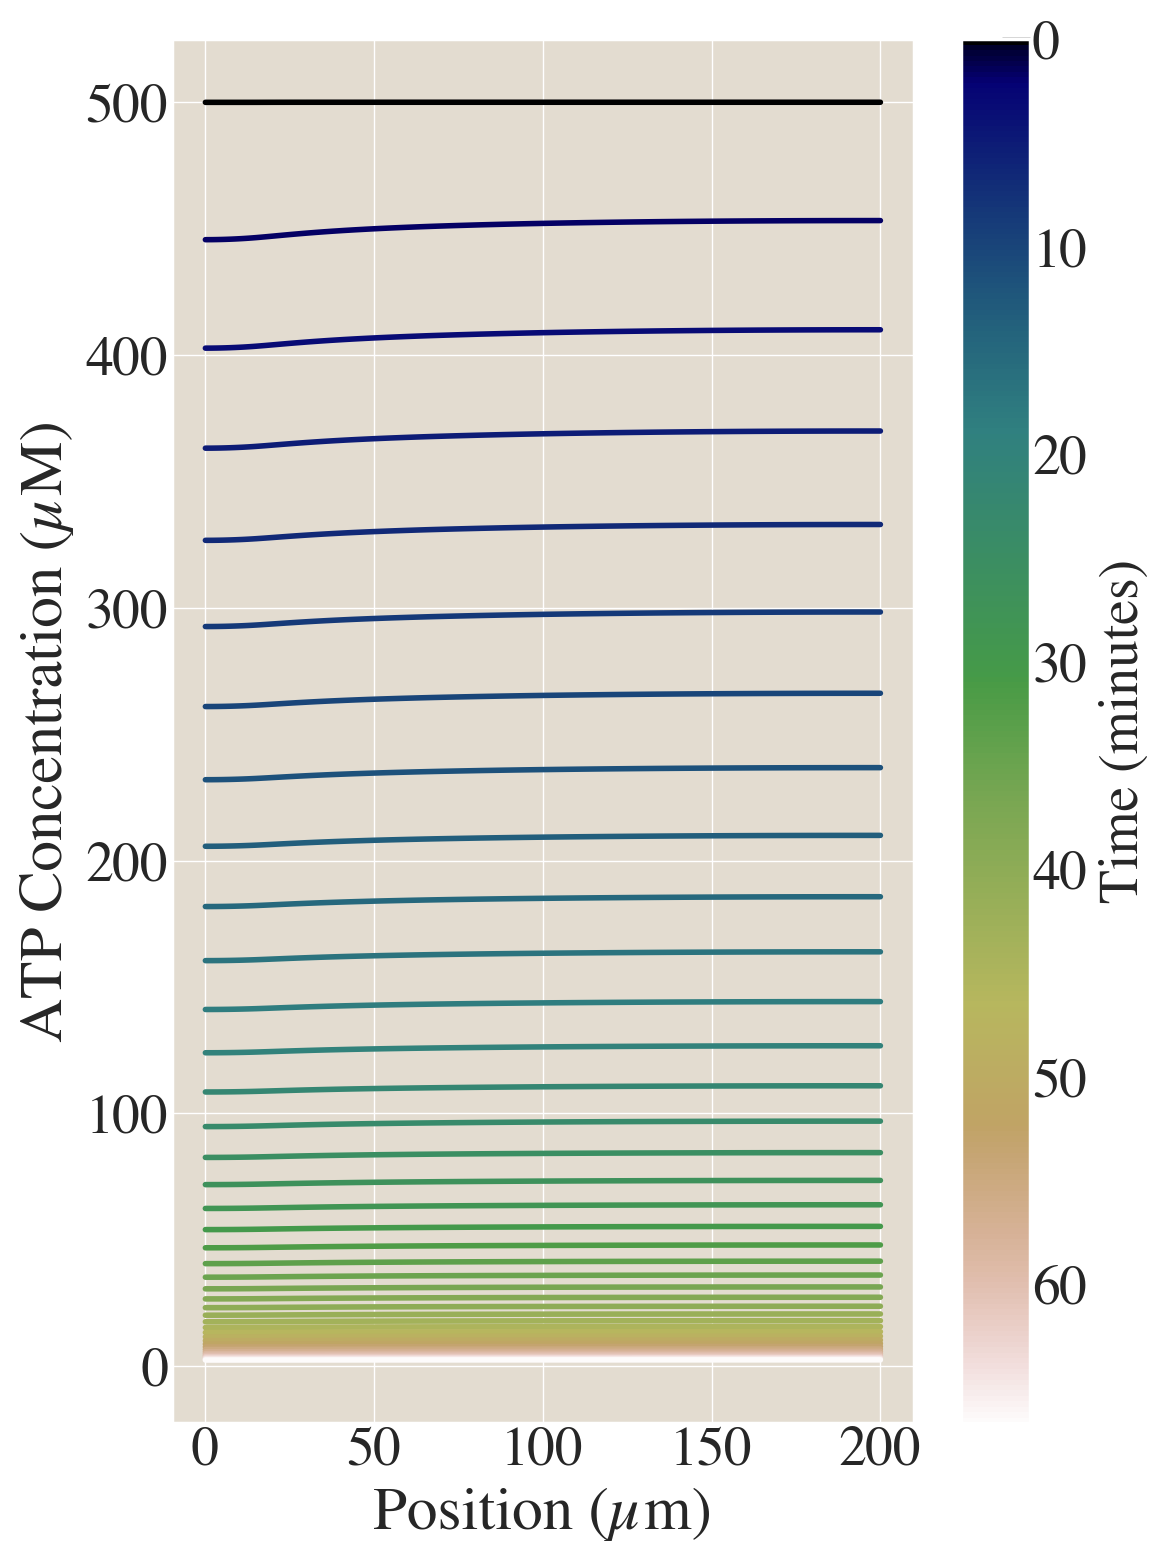

In [57]:
mod_num = 1

fig, ax = plt.subplots(figsize=(6, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=times.min(), vmax=times.max())
colormap = cm.gist_earth

for t in tqdm(times):
#     if t<(times[-1]+1):
#         if t%mod_num==0:
    pos_data = ATP_prof_df.loc[ATP_prof_df['time (min)'] == t, 'position'].values[:]
    conc_data = ATP_prof_df[ATP_prof_df['time (min)'] == t]['ATP Conc'].values[:]
    #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
    ax.plot(pos_data,
             conc_data,
             lw=2,
             color = colormap(normalize(t)),
             label=str(round(t, 1)))


 #ax.set_facecolor(color_background)

#plt.ylim(-0.1, 9.0)
#plt.xlim(-0.01, 1)
plt.xlabel('Position (µm)', fontsize = 22,)
plt.ylabel('ATP Concentration (µM)', fontsize = 22)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20);

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(times)
cbar = plt.colorbar(scalarmappaple, label='Time (minutes)')
cbar.set_label(label='Time (minutes)', fontsize=20)
cbar.ax.tick_params(labelsize=20)
cbar.ax.invert_yaxis()

plt.tight_layout()
#fig.savefig(file_path + file_name + ".png", dpi=300)

Text(0, 0.5, 'Motor Concentration (µM)')

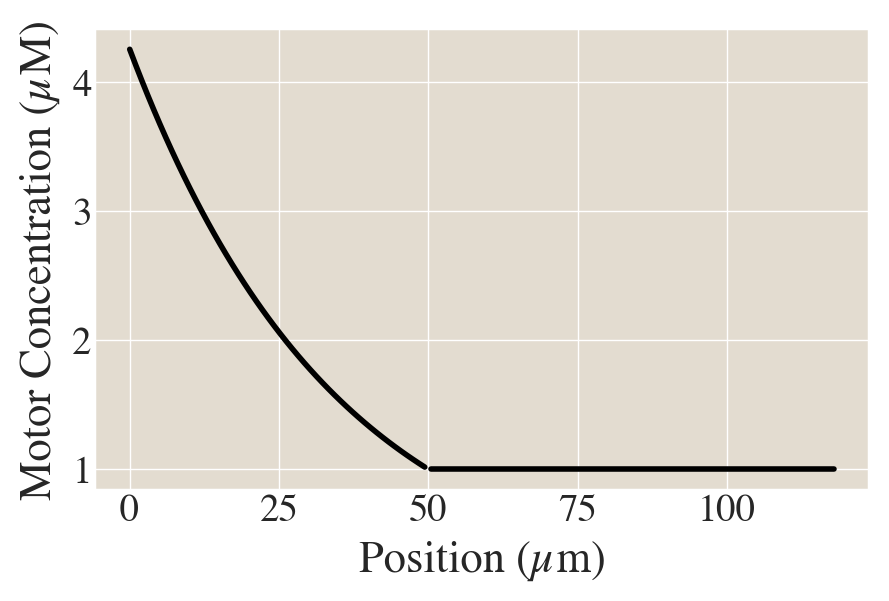

In [45]:
fig, ax = plt.subplots(figsize=(5, 3))

m0 = 1
mmax = 4.252
R = 50
K = 60
lambda_ = 15
coef = (lambda_/R)*np.log(mmax/m0)
r = np.linspace(0, 118, 118)
r_non_dim = r/R
exp = (m0)*np.e**(coef*(R-r)/lambda_)
const = np.ones(118)*m0

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=times.min(), vmax=times.max())
colormap = cm.gist_earth

ax.plot(r[:50],
         exp[:50],
         lw=2,
         color = colormap(normalize(0)),
         label=str(round(t, 1)))
ax.plot(r[50:],
         const[50:],
         lw=2,
         color = colormap(normalize(0)))
        

ax.set_facecolor('#E3DCD0')

#plt.ylim(-0.1, 9.0)
#plt.xlim(0.04, 2.4)
plt.xlabel('Position (µm)')
plt.ylabel('Motor Concentration (µM)')
# plt.xticks(fontsize= 10)
# plt.yticks(fontsize= 10);

# setup the colorbar
#scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
#scalarmappaple.set_array(times)
#cbar = plt.colorbar(scalarmappaple, label = "Time (minutes)")

#plt.tight_layout()
#fig.savefig(file_path + file_name, dpi=300)

In [25]:
m0 = 1
R = 50
K = 60
r = np.linspace(0, 100, 100)
exp = (m0/K)*np.e**((R-r)/R)
const = np.ones(100)*m0/K

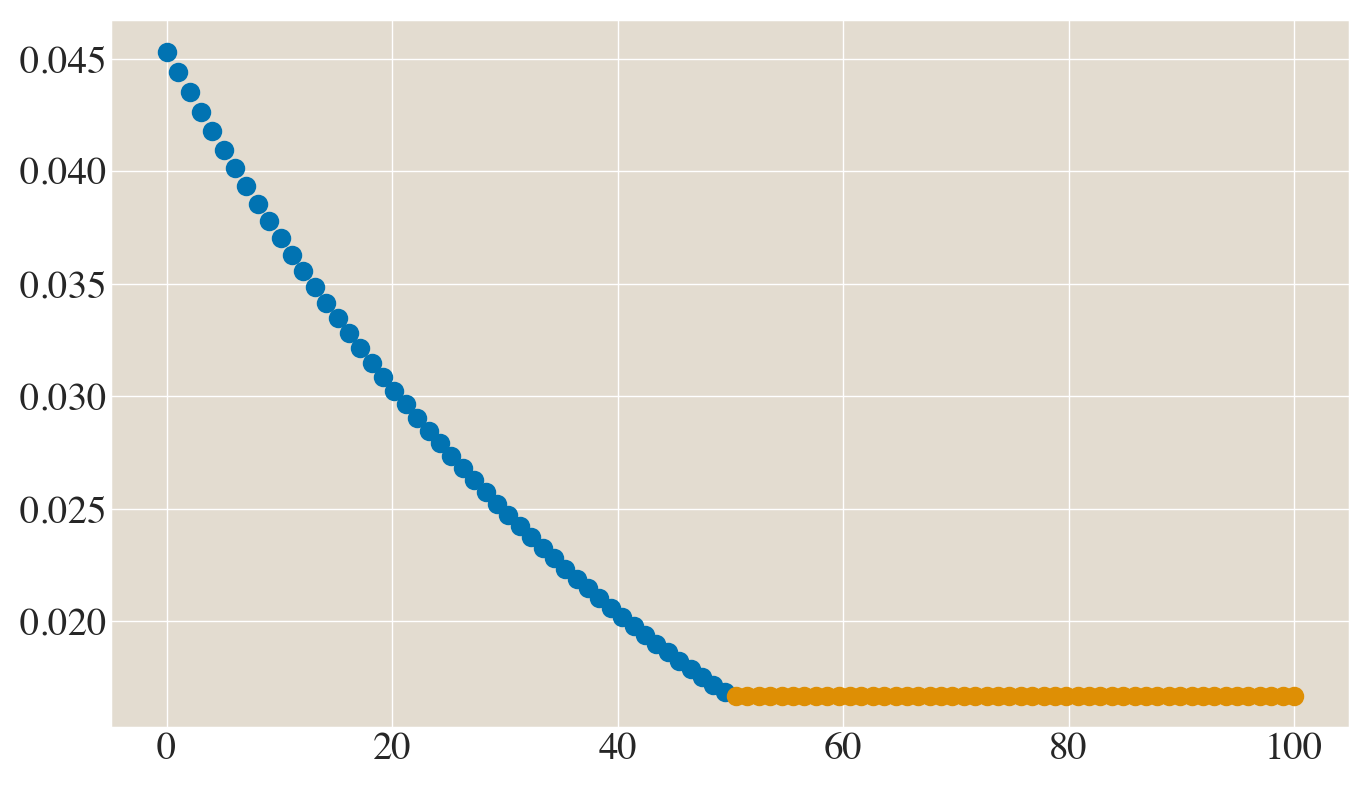

In [26]:
plt.scatter(r[:50], exp[:50])
plt.scatter(r[50:], const[50:])

Text(0.5, 0, 'time (s)')

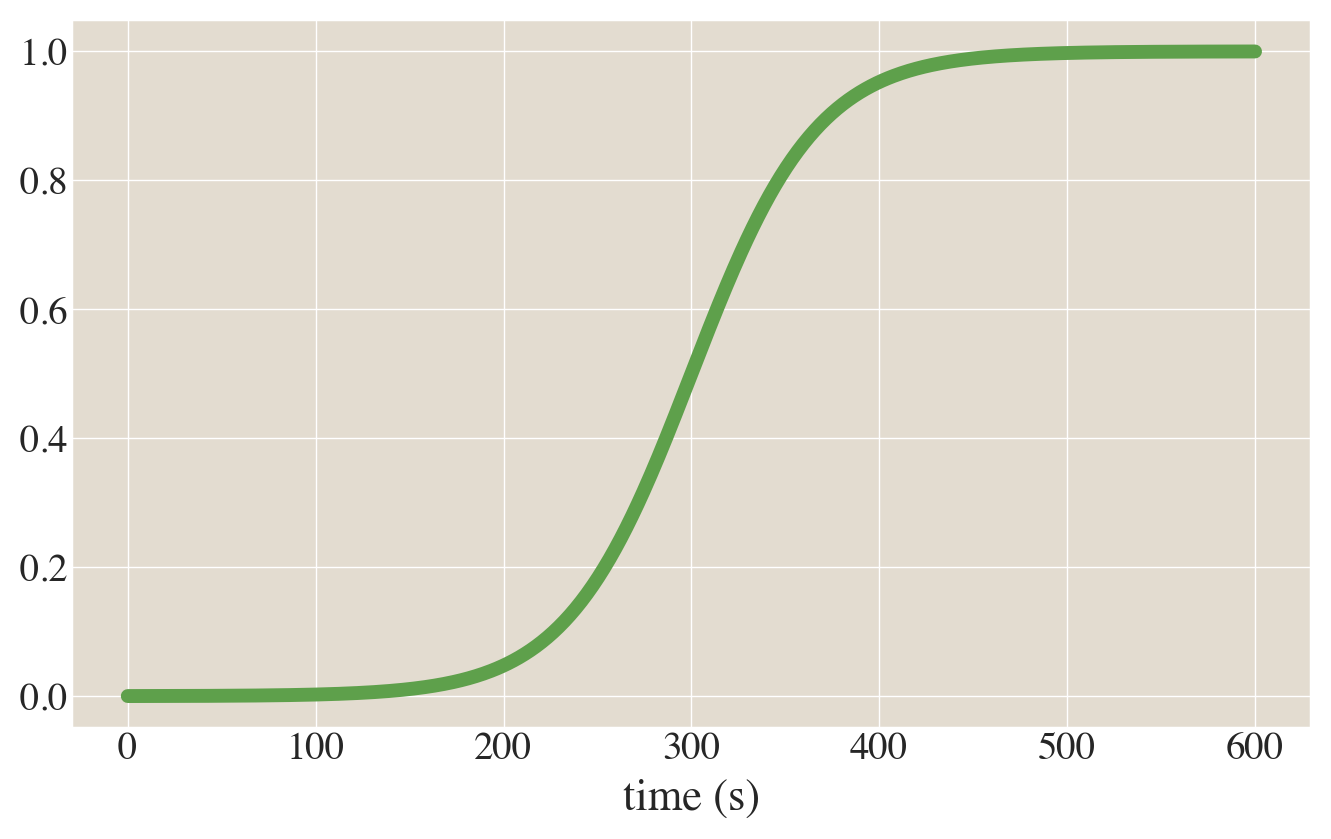

In [27]:
rand = np.linspace(0, 600, 600)
sigmoid = 1/(1+np.exp(0.03*(-rand+300)))
plt.plot(rand, sigmoid, lw=5, color=plt.cm.gist_earth(0.5))
plt.xlabel('time (s)')
